In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import re
import scipy as sp

# Project's package
import sys
try:
    session_params is not None 
    sys.path.append("../auimpy")
    import prepair, air
except NameError:
    session_params = {
    'filters_applied': True, 
    'minimal_accuracy': 60,
    'write_text': True,
    'save_figs': True,
    'input_method': 'mouse',
    'iters_num': 10000,
    'paper_name': 'Ex. 3'
    }
    sys.path.append("../auimpy")
    import prepair, air


data = pd.read_csv('./input/exp3 - ia_index_irrelevant.csv')
demog = pd.read_csv('./input/demog.csv')

In [2]:
# Unfortunatly we have demogrpahics only for 65 / 71 subjects.
print(demog['sex'].value_counts(normalize=True))
print(demog['age'].describe())
print(demog.shape[0])


Female    0.738462
Male      0.261538
Name: sex, dtype: float64
count    65.000000
mean     22.661538
std       3.355392
min      18.000000
25%      20.000000
50%      22.000000
75%      24.000000
max      33.000000
Name: age, dtype: float64
71


In [3]:
# Non-Unique participant numbers - factorizing them by concatenating date and participant number
data['participant'] = data['participant'].astype(str).str.cat(data['date'].values, sep="_").astype('category').cat.codes.values
data['trial'] = data.groupby('participant')['participant'].cumcount()

# # RT in seconds >> RT in MS
data['rt'] = data['rt'].multiply(1000).values

data.rename(columns={'mousePressedStart': 'keys_at_start'}, inplace=True)

# Keep only the relevant columns for further processing of the data
data = data.drop(
    columns=[i for i in data.columns if i not in 
                      ['participant', 'rt', 'keys_at_start',
                       'cueNumber', 'cond', 'distrType', 'response',
                      'trial', 'date']])

# Remap the values to we could get a meaningful comparison with 
# the distractor (which is the finger's name)
data[['cueNumber', 'response', 'distrType']] = (
    data[['cueNumber', 'response', 'distrType']]).replace(
        {1: "Middle", 2: "Ring", "ring": "Ring", "index": "Index", "middle": "Middle"})

# Modify the condition labels. Middle is always irrelevant. 
# Baseline (image) is always Baseline (condition).
data['condition'] = data['distrType'].copy(deep=False).replace(
    {"Index" : "Irrelevant", "baseline": "Baseline"}).values

# Compare the distractor and cue and based on the comparison label the condition
data.loc[data['distrType'].isin(['Middle', 'Ring']), 'condition'] = np.where(
    data.loc[data['distrType'].isin(['Middle', 'Ring']), ["distrType", "cueNumber"]].apply(
        lambda x: x[0] == x[1], axis=1), "Compatible", "Incompatible") 

# Label response accuracy
data['correct'] = np.where(data['cueNumber'] == data['response'], True, False)

data.rename(columns={'cueNumber': 'cuenumber'}, inplace=True)


In [4]:
prpr = prepair.PrepAIR(data=data, **session_params)

In [5]:
prpr.report_invalid_trials()

'Invalid trials included incorrect or omitted responses (12.51%), slow responses (>950ms, 2.2%) fast responses (<150ms, 4.63%), and trials in which participants did not press the keys down correctly in the beginning of the trial (8.07%). Finally, all data from 8 participants (<60% valid trials, 11.27% of 71) were removed. Total filtration amounted to 21.71%.'

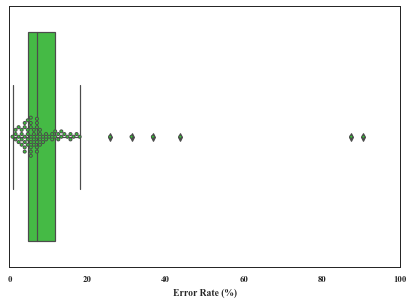

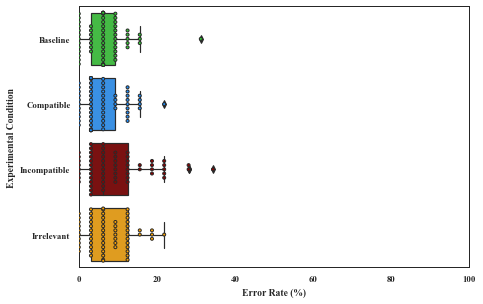

In [6]:
# Pre Filteration
prpr.plot_descriptives('er', pre_filteration=True)
# Post Filteration
prpr.plot_descriptives('er', by_condition=True, pre_filteration=False)

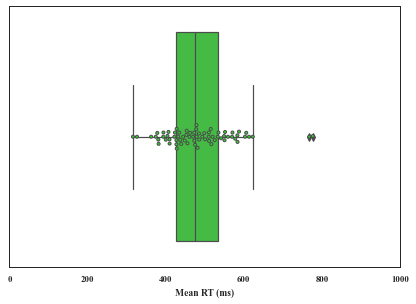

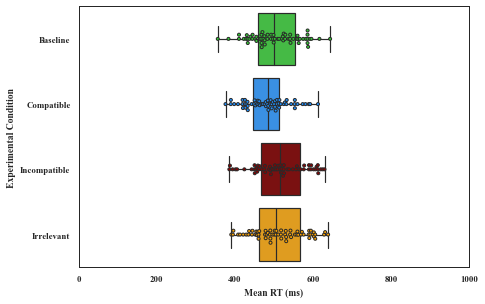

In [7]:
# Pre Filteration
prpr.plot_descriptives('rt', pre_filteration=True)
# Post Filteration
prpr.plot_descriptives('rt', by_condition=True, pre_filteration=False)

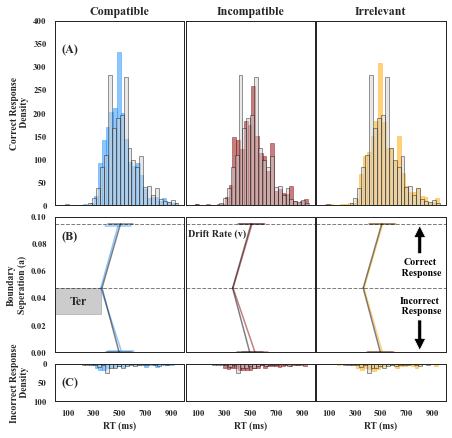

In [8]:
prpr.plot_diffusion()

In [9]:
*dfs, summary = prpr.get_finalized_data()
summary

,Mean Response Time,Error Rate,Drift Rate,Boundary Separation,Non-Decision Time
Condition (n = 63),,,,,
Baseline,503.35 (61.88),6.55 (5.35),0.301 (0.064),0.095 (0.016),363.1 (47.89)
Compatible,484.26 (53.96),6.05 (5.11),0.324 (0.077),0.092 (0.016),353.86 (42.73)
Incompatible,514.92 (64.81),9.47 (7.98),0.269 (0.083),0.094 (0.015),366.7 (52.22)
Irrelevant,512.87 (65.63),7.44 (5.51),0.289 (0.069),0.095 (0.016),368.75 (50.27)


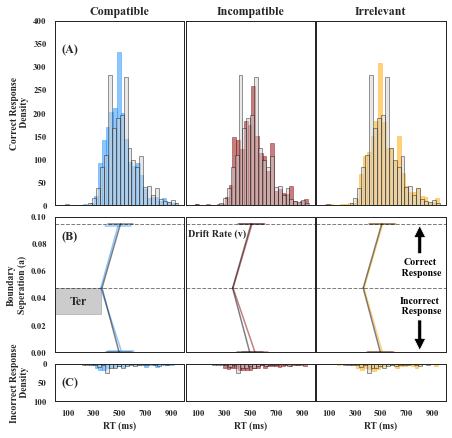

In [10]:
prpr.plot_diffusion()

In [11]:
rep = air.AIR(*dfs, **session_params)

C:\Users\Eitan Hemed\.conda\envs\pyr_env\lib\site-packages\rpy2\robjects\pandas2ri.py:67: UserWarning: Error while trying to convert the column "index". Fall back to string conversion. The error is: Conversion 'py2ri' not defined for objects of type '<class 'pandas.core.series.Series'>'
  (name, str(e)))
C:\Users\Eitan Hemed\.conda\envs\pyr_env\lib\site-packages\rpy2\robjects\pandas2ri.py:67: UserWarning: Error while trying to convert the column "participant". Fall back to string conversion. The error is: Conversion 'py2ri' not defined for objects of type '<class 'pandas.core.series.Series'>'
  (name, str(e)))
C:\Users\Eitan Hemed\.conda\envs\pyr_env\lib\site-packages\rpy2\robjects\pandas2ri.py:67: UserWarning: Error while trying to convert the column "condition". Fall back to string conversion. The error is: Conversion 'py2ri' not defined for objects of type '<class 'pandas.core.series.Series'>'
  (name, str(e)))
C:\Users\Eitan Hemed\.conda\envs\pyr_env\lib\site-packages\rpy2\robjects

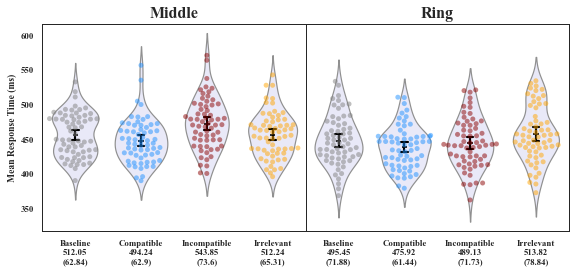

In [12]:
rep.plot_rt_by_fingers()

Repeated-Measures ANOVA showed a significant effect of experimental condition on Mean Response Time [F(2, 122) = 37.13, p < 0.001, Partial-η Squared = 0.375]
The Compatible condition Lower-tail t(62) = -5.06, p < 0.001, Mean Response Time Change -19.08ms, Cohen's d = -0.64 95%-CI [-0.91, -0.37], BF1:0 = 8516.000
The Incompatible condition Upper-tail t(62) = 3.57, p < 0.001, Mean Response Time Change 11.57ms, Cohen's d = 0.45 95%-CI [0.19, 0.71], BF1:0 = 73.460
The Irrelevant condition Two-tail t(62) = 2.63, p = 0.011, Mean Response Time Change 9.52ms, Cohen's d = 0.33 95%-CI [0.08, 0.59], BF1:0 = 3.240


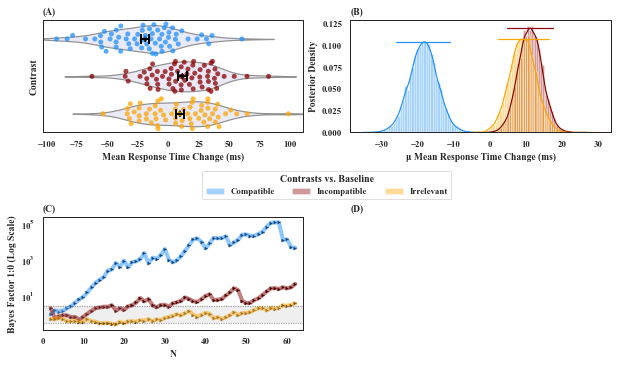

In [13]:
rep.report_results('rt')

Repeated-Measures ANOVA showed a significant effect of experimental condition on Error Rate [F(2, 102) = 9.52, p < 0.001, Partial-η Squared = 0.133]
The Compatible condition Lower-tail t(62) = -0.73, p = 0.236, Error Rate Change -0.50%, Cohen's d = -0.09 95%-CI [-0.34, 0.16], BF1:0 = 0.270
The Incompatible condition Upper-tail t(62) = 3.17, p = 0.001, Error Rate Change 2.93%, Cohen's d = 0.40 95%-CI [0.14, 0.66], BF1:0 = 24.610
The Irrelevant condition Two-tail t(62) = 1.17, p = 0.247, Error Rate Change 0.89%, Cohen's d = 0.15 95%-CI [-0.10, 0.40], BF1:0 = 0.260


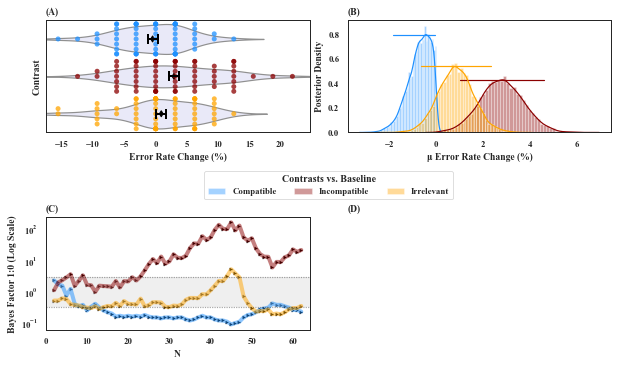

In [14]:
rep.report_results('er')

Repeated-Measures ANOVA showed a significant effect of experimental condition on Drift Rate [F(2, 122) = 19.59, p < 0.001, Partial-η Squared = 0.240]
The Compatible condition Upper-tail t(62) = 2.52, p = 0.007, Drift Rate Change 0.0231v, Cohen's d = 0.32 95%-CI [0.07, 0.57], BF1:0 = 5.000
The Incompatible condition Lower-tail t(62) = -3.36, p = 0.001, Drift Rate Change -0.0318v, Cohen's d = -0.43 95%-CI [-0.68, -0.17], BF1:0 = 40.880
The Irrelevant condition Two-tail t(62) = -1.24, p = 0.221, Drift Rate Change -0.0123v, Cohen's d = -0.16 95%-CI [-0.41, 0.09], BF1:0 = 0.280


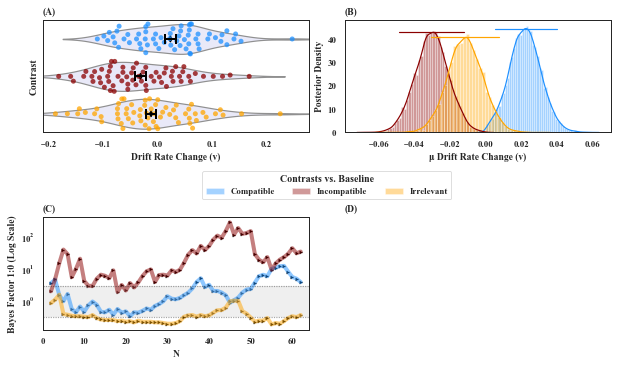

In [15]:
rep.report_results('drift_rate')

Repeated-Measures ANOVA showed an insignificant effect of experimental condition on Boundary Separation [F(2, 122) = 0.82, p = 0.440, Partial-η Squared = 0.013]
The Compatible condition Lower-tail t(62) = -1.07, p = 0.145, Boundary Separation Change -0.0025a, Cohen's d = -0.14 95%-CI [-0.38, 0.11], BF1:0 = 0.400
The Incompatible condition Upper-tail t(62) = -0.10, p = 0.541, Boundary Separation Change -0.0003a, Cohen's d = -0.01 95%-CI [-0.26, 0.23], BF1:0 = 0.130
The Irrelevant condition Two-tail t(62) = 0.09, p = 0.927, Boundary Separation Change 0.0002a, Cohen's d = 0.01 95%-CI [-0.23, 0.26], BF1:0 = 0.140


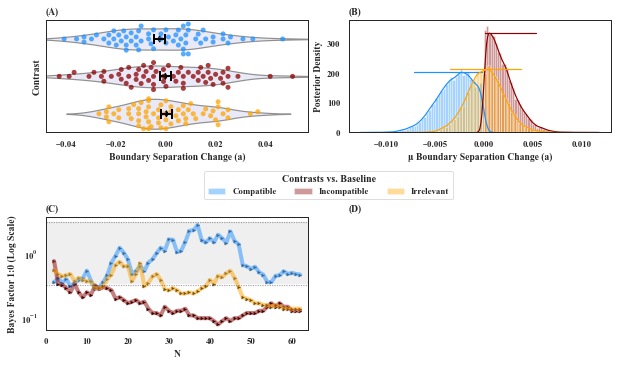

In [16]:
rep.report_results('boundary_separation')

Repeated-Measures ANOVA showed a significant effect of experimental condition on Non-Decision Time [F(2, 123) = 5.18, p = 0.007, Partial-η Squared = 0.077]
The Compatible condition Lower-tail t(62) = -2.07, p = 0.021, Non-Decision Time Change -0.0092s, Cohen's d = -0.26 95%-CI [-0.51, -0.01], BF1:0 = 1.960
The Incompatible condition Upper-tail t(62) = 0.76, p = 0.226, Non-Decision Time Change 0.0036s, Cohen's d = 0.10 95%-CI [-0.15, 0.34], BF1:0 = 0.280
The Irrelevant condition Two-tail t(62) = 1.32, p = 0.192, Non-Decision Time Change 0.0057s, Cohen's d = 0.17 95%-CI [-0.08, 0.41], BF1:0 = 0.310


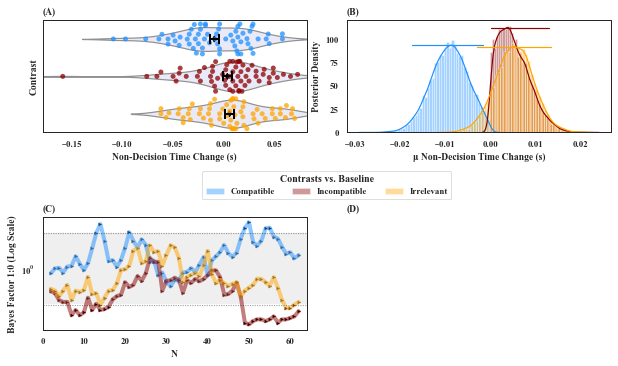

In [17]:
rep.report_results('non_decision_time')